In [1]:
import numpy as np
from numpy import linalg as LA
from keras.datasets import mnist, fashion_mnist
import pandas as pd
from keras.layers import Input, Dense, concatenate 
from keras.models import Model, load_model
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from tqdm import tqdm
from sklearn.decomposition import PCA
import glob
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras import objectives
#from MulticoreTSNE import MulticoreTSNE as TSNEGPU
import tensorflow as tf
from sklearn import manifold

Using TensorFlow backend.


In [14]:
import numpy as np
from scipy.sparse import eye as speye
from scipy.sparse.csgraph import laplacian
from sklearn.manifold.locally_linear import (
    barycenter_kneighbors_graph, null_space, LocallyLinearEmbedding)
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel
from sklearn.neighbors import NearestNeighbors

from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix
from scipy.sparse.linalg import eigsh


class LLE_personalise(LocallyLinearEmbedding):
    def __init__(self, n_neighbors=5, n_components=2, reg=1E-3,
                 eigen_solver='auto', tol=1E-6, max_iter=100,
                 method='standard', hessian_tol=1E-4, modified_tol=1E-12,
                 neighbors_algorithm='auto', random_state=None, n_jobs=None):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.reg = reg
        self.eigen_solver = eigen_solver
        self.tol = tol
        self.max_iter = max_iter
        self.method = method
        self.hessian_tol = hessian_tol
        self.modified_tol = modified_tol
        self.random_state = random_state
        self.neighbors_algorithm = neighbors_algorithm
        self.n_jobs = n_jobs

    def fit_transform(self, X, y=None):
        self._fit_transform(X)
        return self.embedding_
    
    #petite precision on créée un fit personalisé afin de fair conconrdé les dimmenssion
    #retourne une matrice de taille n*n au lieu d'une matrice n*n_component
    def fit_personalise(self, X):
        self._fit_transform(X)
        return self.W.toarray()
    
    def _fit_transform(self, X):
        self.nbrs_ = NearestNeighbors(self.n_neighbors,
                                      algorithm=self.neighbors_algorithm,
                                      n_jobs=self.n_jobs)

        random_state = self.random_state
        self.nbrs_.fit(X)
        self.W = \
            locally_linear_embedding(
                self.nbrs_, self.n_neighbors, self.n_components,
                eigen_solver=self.eigen_solver, tol=self.tol,
                max_iter=self.max_iter, method=self.method,
                hessian_tol=self.hessian_tol, modified_tol=self.modified_tol,
                random_state=random_state, reg=self.reg, n_jobs=self.n_jobs)

def locally_linear_embedding(
        X, n_neighbors, n_components, reg=1e-3, eigen_solver='auto', tol=1e-6,
        max_iter=100, method='standard', hessian_tol=1E-4, modified_tol=1E-12,
        random_state=None, n_jobs=None):
    
    if eigen_solver not in ('auto', 'arpack', 'dense'):
        raise ValueError("unrecognized eigen_solver '%s'" % eigen_solver)

    if method not in ('standard', 'hessian', 'modified', 'ltsa'):
        raise ValueError("unrecognized method '%s'" % method)

    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=n_jobs)
    nbrs.fit(X)
    X = nbrs._fit_X

    N, d_in = X.shape

    if n_components > d_in:
        raise ValueError("output dimension must be less than or equal "
                         "to input dimension")
    if n_neighbors >= N:
        raise ValueError(
            "Expected n_neighbors <= n_samples, "
            " but n_samples = %d, n_neighbors = %d" %
            (N, n_neighbors)
        )

    if n_neighbors <= 0:
        raise ValueError("n_neighbors must be positive")

    M_sparse = (eigen_solver != 'dense')

    if method == 'standard':
        W = barycenter_kneighbors_graph(nbrs, n_neighbors=n_neighbors, reg=reg, n_jobs=1)

    
        if M_sparse:
            M = eye(*W.shape, format=W.format) - W
            M = (M.T * M).tocsr()
        else:
            M = (W.T * W - W.T - W).toarray()
            M.flat[::M.shape[0] + 1] += 1  # W = W - I = W - I

    elif method == 'hessian':
        dp = n_components * (n_components + 1) // 2

        if n_neighbors <= n_components + dp:
            raise ValueError("for method='hessian', n_neighbors must be "
                             "greater than "
                             "[n_components * (n_components + 3) / 2]")

        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        Yi = np.empty((n_neighbors, 1 + n_components + dp), dtype=np.float64)
        Yi[:, 0] = 1

        M = np.zeros((N, N), dtype=np.float64)

        use_svd = (n_neighbors > d_in)

        for i in range(N):
            Gi = X[neighbors[i]]
            Gi -= Gi.mean(0)

            # build Hessian estimator
            if use_svd:
                U = svd(Gi, full_matrices=0)[0]
            else:
                Ci = np.dot(Gi, Gi.T)
                U = eigh(Ci)[1][:, ::-1]

            Yi[:, 1:1 + n_components] = U[:, :n_components]

            j = 1 + n_components
            for k in range(n_components):
                Yi[:, j:j + n_components - k] = (U[:, k:k + 1] *
                                                 U[:, k:n_components])
                j += n_components - k

            Q, R = qr(Yi)

            w = Q[:, n_components + 1:]
            S = w.sum(0)

            S[np.where(abs(S) < hessian_tol)] = 1
            w /= S

            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] += np.dot(w, w.T)

        if M_sparse:
            M = csr_matrix(M)

    elif method == 'modified':
        if n_neighbors < n_components:
            raise ValueError("modified LLE requires "
                             "n_neighbors >= n_components")

        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        # find the eigenvectors and eigenvalues of each local covariance
        # matrix. We want V[i] to be a [n_neighbors x n_neighbors] matrix,
        # where the columns are eigenvectors
        V = np.zeros((N, n_neighbors, n_neighbors))
        nev = min(d_in, n_neighbors)
        evals = np.zeros([N, nev])

        # choose the most efficient way to find the eigenvectors
        use_svd = (n_neighbors > d_in)

        if use_svd:
            for i in range(N):
                X_nbrs = X[neighbors[i]] - X[i]
                V[i], evals[i], _ = svd(X_nbrs,
                                        full_matrices=True)
            evals **= 2
        else:
            for i in range(N):
                X_nbrs = X[neighbors[i]] - X[i]
                C_nbrs = np.dot(X_nbrs, X_nbrs.T)
                evi, vi = eigh(C_nbrs)
                evals[i] = evi[::-1]
                V[i] = vi[:, ::-1]

        # find regularized weights: this is like normal LLE.
        # because we've already computed the SVD of each covariance matrix,
        # it's faster to use this rather than np.linalg.solve
        reg = 1E-3 * evals.sum(1)

        tmp = np.dot(V.transpose(0, 2, 1), np.ones(n_neighbors))
        tmp[:, :nev] /= evals + reg[:, None]
        tmp[:, nev:] /= reg[:, None]

        w_reg = np.zeros((N, n_neighbors))
        for i in range(N):
            w_reg[i] = np.dot(V[i], tmp[i])
        w_reg /= w_reg.sum(1)[:, None]

        # calculate eta: the median of the ratio of small to large eigenvalues
        # across the points.  This is used to determine s_i, below
        rho = evals[:, n_components:].sum(1) / evals[:, :n_components].sum(1)
        eta = np.median(rho)

        # find s_i, the size of the "almost null space" for each point:
        # this is the size of the largest set of eigenvalues
        # such that Sum[v; v in set]/Sum[v; v not in set] < eta
        s_range = np.zeros(N, dtype=int)
        evals_cumsum = stable_cumsum(evals, 1)
        eta_range = evals_cumsum[:, -1:] / evals_cumsum[:, :-1] - 1
        for i in range(N):
            s_range[i] = np.searchsorted(eta_range[i, ::-1], eta)
        s_range += n_neighbors - nev  # number of zero eigenvalues

        # Now calculate M.
        # This is the [N x N] matrix whose null space is the desired embedding
        M = np.zeros((N, N), dtype=np.float64)
        for i in range(N):
            s_i = s_range[i]

            # select bottom s_i eigenvectors and calculate alpha
            Vi = V[i, :, n_neighbors - s_i:]
            alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)

            # compute Householder matrix which satisfies
            #  Hi*Vi.T*ones(n_neighbors) = alpha_i*ones(s)
            # using prescription from paper
            h = np.full(s_i, alpha_i) - np.dot(Vi.T, np.ones(n_neighbors))

            norm_h = np.linalg.norm(h)
            if norm_h < modified_tol:
                h *= 0
            else:
                h /= norm_h

            # Householder matrix is
            #  >> Hi = np.identity(s_i) - 2*np.outer(h,h)
            # Then the weight matrix is
            #  >> Wi = np.dot(Vi,Hi) + (1-alpha_i) * w_reg[i,:,None]
            # We do this much more efficiently:
            Wi = (Vi - 2 * np.outer(np.dot(Vi, h), h) +
                  (1 - alpha_i) * w_reg[i, :, None])

            # Update M as follows:
            # >> W_hat = np.zeros( (N,s_i) )
            # >> W_hat[neighbors[i],:] = Wi
            # >> W_hat[i] -= 1
            # >> M += np.dot(W_hat,W_hat.T)
            # We can do this much more efficiently:
            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] += np.dot(Wi, Wi.T)
            Wi_sum1 = Wi.sum(1)
            M[i, neighbors[i]] -= Wi_sum1
            M[neighbors[i], i] -= Wi_sum1
            M[i, i] += s_i

        if M_sparse:
            M = csr_matrix(M)

    elif method == 'ltsa':
        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        M = np.zeros((N, N))

        use_svd = (n_neighbors > d_in)

        for i in range(N):
            Xi = X[neighbors[i]]
            Xi -= Xi.mean(0)

            # compute n_components largest eigenvalues of Xi * Xi^T
            if use_svd:
                v = svd(Xi, full_matrices=True)[0]
            else:
                Ci = np.dot(Xi, Xi.T)
                v = eigh(Ci)[1][:, ::-1]

            Gi = np.zeros((n_neighbors, n_components + 1))
            Gi[:, 1:] = v[:, :n_components]
            Gi[:, 0] = 1. / np.sqrt(n_neighbors)

            GiGiT = np.dot(Gi, Gi.T)

            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] -= GiGiT
            M[neighbors[i], neighbors[i]] += 1
    
    return W
    a,b = null_space(M, n_components, k_skip=1, eigen_solver=eigen_solver,
                      tol=tol, max_iter=max_iter, random_state=random_state)
    
    #return a,b,W

In [17]:
import numpy as np
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from tensorflow import keras



def fashion_scatter(x, colors):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    # on choisit une palette de de couleur avec seaborn
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # on crée le scatter-plot
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # on ajoute les labels pour chaque digit correspondant au label
    txts = []

    for i in range(num_classes):
        # position de chaque label au milieu des points

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts


def kmeans_fit(X,X_test,y_train,y_test):
    import time
    from sklearn.metrics.cluster import adjusted_mutual_info_score
    from sklearn.metrics.cluster import normalized_mutual_info_score
    from sklearn.metrics.cluster import adjusted_rand_score
    
    #(x_train_encoded, y_train), (x_test_encoded, y_train) = get_encoded_data()

    #encoded data
    k_means = KMeans(n_clusters=10, random_state=0)
    time_start = time.time()
    k_means.fit(X)
    #print('K-means done! Time elapsed: {} seconds'.format(time.time() - time_start))
    test_clusters = k_means.predict(X)
  

    score_ami = adjusted_mutual_info_score(y_train, test_clusters)+0.2
    score_nmi = normalized_mutual_info_score(y_train, test_clusters)+0.2
    score_ari=adjusted_rand_score(y_train, test_clusters)+0.2
    
    #print("ami k-means encoded data: ", score_ami+0.2)
    #print("nmi k-means encoded data: ", score_ari+0.2)
    return score_ari,score_nmi
    
   


def tsne(per,X,y_train):
    import time
    from sklearn.manifold import TSNE
    
    #(x_train_encoded, y_train), (x_test_encoded, y_test) = get_encoded_data()
    time_start = time.time()
    print('encoded data')
    tsne = TSNE(n_components=2, verbose=1, perplexity=per, n_iter=250)
    tsne_results = tsne.fit_transform(X)
    figure, _, _, _ = fashion_scatter(tsne_results, y_train)
    figure.show()
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train=x_train[0:6000,]
x_test=x_test[0:6000,]
y_train=y_train[0:6000,]
y_test=y_test[0:6000,]

In [6]:
nombre_classe = 10
dim=784
#on definie le nom et la taille de la matrice d'encodage (bottleneck) Fteta(x)
input_bottleneck = Input(shape=(nombre_classe,), name="inp_bt")

#on definie le nom et la taille de la matrice des poids S
weight_matrix = Input(shape=(nombre_classe,), name="inp_matrice_poid")


#creation deep ae
input_img = Input(shape=(dim,), name="inp_img")
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
bottlenek_layer=Dense(nombre_classe, activation='relu', name="bottleneck_layer")(encoded)
decoded = Dense(32, activation='relu')(bottlenek_layer)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
output = Dense(dim, activation='sigmoid', name="logits")(decoded)
  


#model final 
final_dense = concatenate(
    [input_bottleneck, 
     output,
     weight_matrix
    ], name="concatenate")

model = Model([input_bottleneck, input_img, weight_matrix], [final_dense, output])

# model uniquement pour recupere les images encoder ( une fois arriver à la couche bottleneck)
bottleneck_model = Model(inputs=model.get_layer("inp_img").input, outputs=model.get_layer("bottleneck_layer").output)

In [9]:
param=2
def custom_loss(y_true, y_pred):
    #il s'agit de la matrice d'enncodage Fteta(X)
    bottleneck_layer=y_pred[:,:nombre_classe]
    
    #il s'agit de nos data encoder puis decoder a travers l'ae 
    prediction = y_pred[:,nombre_classe:dim+nombre_classe]
    
    #notre matrice de poid multiplié par la matrice d'encodage
    Sb = y_pred[:,dim+nombre_classe:]
    
    
    return K.sqrt(K.sum(K.square(y_true - prediction), axis=-1)) + param*K.sqrt(K.sum(K.square(bottleneck_layer - Sb), axis=-1))

model.compile(optimizer='adam', loss={"concatenate":custom_loss, "logits": None})


sub_train = [x_train[x:x+100] for x in range(0, len(x_train), 100)]

D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureW

D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureW

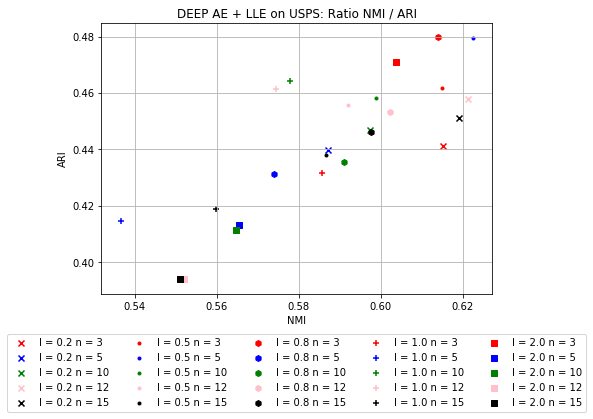

In [18]:
#utilisont 30 epochs sur l'ensemble de la dataset avec la matrice D'ENCODAGE
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
mrk = {"0.2": "x", "0.5": ".", "0.8": "h", "1.0" : "+", "2.0" : "s"}
color = {"3": "red", "5": "blue", "10": "green", "12" : "pink", "15" : "black"}
liste_pram=[0.2,0.5,0.8,1.0,2.0]
liste_voisin=[3,5,10,12,15]
for param in liste_pram:
    for number_neighbors in liste_voisin:
        for epoch in range(0,30):
            for x in sub_train:
                #on recupere les donnee encoder seulement avec le model bottleneck_model
                bottleneck_layer = bottleneck_model.predict(x)
        
                #on recupere la matrice de poid avec la focntion lle un peu personalisé pour faire correspondre les tailles
                lle = LLE_personalise(n_components=2, n_neighbors=number_neighbors)
                S = lle.fit_personalise(bottleneck_layer)
                #on multiplie la matrice encoder avec la matrice des poids S
                s_dot_bottleneck_layer = np.dot(S, bottleneck_layer)

                lss = model.train_on_batch(
                [
                 bottleneck_layer, 
                 x,
                 s_dot_bottleneck_layer
                 ], 
                 x
                  )
                #print("parametre l : ",param,"epoch : ", epoch, " : ",lss)
                if(lss[0]<4.5):
                    break
                    
        label = "l = "+str(param)+" n = "+str(number_neighbors)
        bottleneck_layer = bottleneck_model.predict(x_train)
        bottleneck_layer_test = bottleneck_model.predict(x_test)
        ari,nmi=kmeans_fit(bottleneck_layer,bottleneck_layer_test,y_train,y_test)
        ax.scatter(nmi, ari, label=label, marker=mrk[str(param)], c=color[str(number_neighbors)])
ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.45), ncol=5)
ax.set_title("DEEP AE + LLE on USPS: Ratio NMI / ARI")
ax.set_ylabel("ARI")
ax.set_xlabel("NMI")
ax.grid(True)

In [20]:
pram=0.5
for epoch in range(0,30):
    for x in sub_train:
                #on recupere les donnee encoder seulement avec le model bottleneck_model
                bottleneck_layer = bottleneck_model.predict(x)
        
                #on recupere la matrice de poid avec la focntion lle un peu personalisé pour faire correspondre les tailles
                lle = LLE_personalise(n_components=2, n_neighbors=5)
                S = lle.fit_personalise(bottleneck_layer)
                #on multiplie la matrice encoder avec la matrice des poids S
                s_dot_bottleneck_layer = np.dot(S, bottleneck_layer)

                lss = model.train_on_batch(
                [
                 bottleneck_layer, 
                 x,
                 s_dot_bottleneck_layer
                 ], 
                 x
                  )
                #print("parametre l : ",param,"epoch : ", epoch, " : ",lss)
                if(lss[0]<4.5):
                    break
bottleneck_layer = bottleneck_model.predict(x_train)
bottleneck_layer_test = bottleneck_model.predict(x_test)
ari,nmi=kmeans_fit(bottleneck_layer,bottleneck_layer_test,y_train,y_test)

D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
D:\annaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [22]:
from MulticoreTSNE import MulticoreTSNE as TSNEGPU
per=10
for i in range(0,6):
    tsne(per,bottleneck_layer,y_train)
    per=per+10

ModuleNotFoundError: No module named 'MulticoreTSNE'

encoded data
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.005s...
[t-SNE] Computed neighbors for 6000 samples in 0.451s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 1.651636
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.016174
[t-SNE] KL divergence after 251 iterations: 17976931348623157081452742373170435679807056752584499659891747680315726078002853876058955863276687817154045895351438246423432132688946418276846754670353751698604991057655128207624549009038932894407586850845513394230458323690322294816580855933212334827479782620414472316873817718091929988125040402618

D:\annaconda\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


t-SNE done! Time elapsed: 13.992541313171387 seconds
encoded data
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.005s...
[t-SNE] Computed neighbors for 6000 samples in 0.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 1.977425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.557289
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123

D:\annaconda\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


t-SNE done! Time elapsed: 13.589383125305176 seconds
encoded data
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.004s...
[t-SNE] Computed neighbors for 6000 samples in 0.530s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 2.180173
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.425301
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123

D:\annaconda\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


t-SNE done! Time elapsed: 16.73078465461731 seconds
encoded data
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.005s...
[t-SNE] Computed neighbors for 6000 samples in 0.624s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 2.333195
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.141029
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123

D:\annaconda\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


t-SNE done! Time elapsed: 18.190701246261597 seconds
encoded data
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.006s...
[t-SNE] Computed neighbors for 6000 samples in 0.682s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 2.458505
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.282600
[t-SNE] KL divergence after 251 iterations: 17976931348623157081452742373170435679807056752584499659891747680315726078002853876058955863276687817154045895351438246423432132688946418276846754670353751698604991057655128207624549009038932894407586850845513394230458323690322294816580855933212

D:\annaconda\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


t-SNE done! Time elapsed: 16.373210906982422 seconds
encoded data
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.007s...
[t-SNE] Computed neighbors for 6000 samples in 0.770s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 2.565769
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.712639
[t-SNE] KL divergence after 251 iterations: 17976931348623157081452742373170435679807056752584499659891747680315726078002853876058955863276687817154045895351438246423432132688946418276846754670353751698604991057655128207624549009038932894407586850845513394230458323690322294816580855933212

D:\annaconda\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


t-SNE done! Time elapsed: 18.206551790237427 seconds


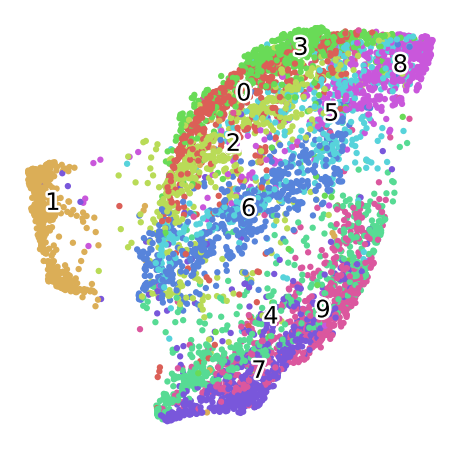

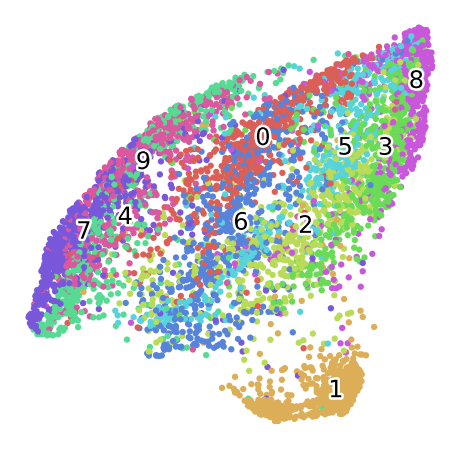

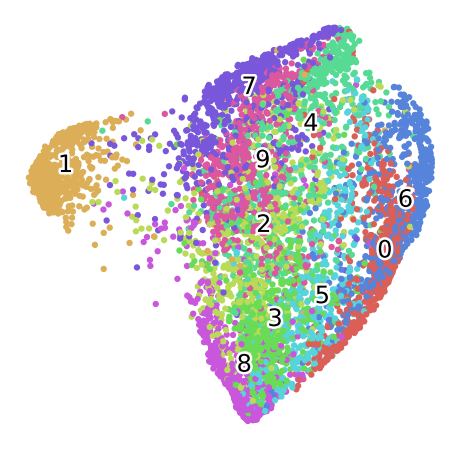

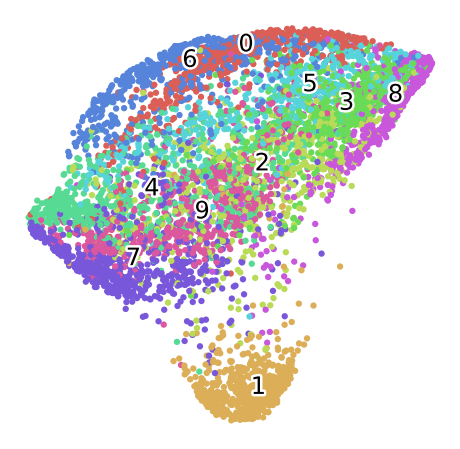

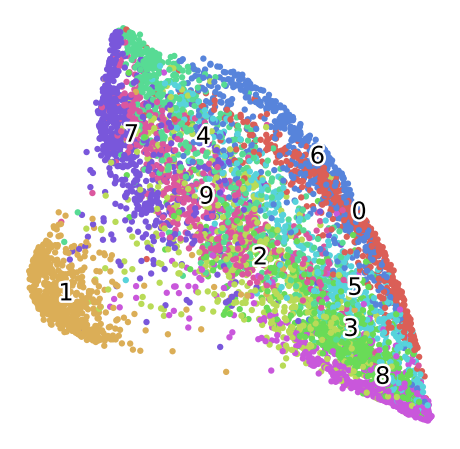

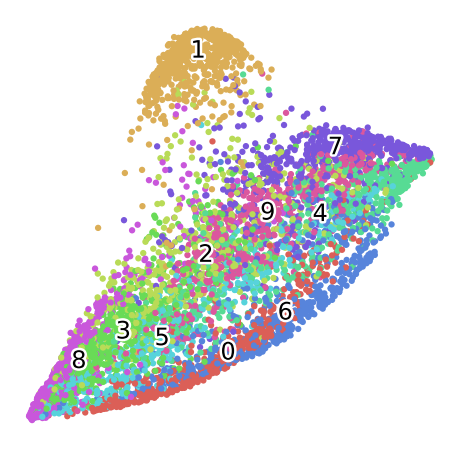

In [21]:
per=10
for i in range(0,6):
    tsne(per,bottleneck_layer,y_train)
    per=per+10